### 传热正向计算

对于稳态传热，研究具有角方向对称性的密封环，使用PINN方法，并将结果与有限元进行对比

In [6]:
from math import pi as PI
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
import ast

from PINN.diff import diff
from PINN.networks import FCNN,Resnet
from PINN.generators import generator_2dspatial_rectangle, generator_2dspatial_segment
from PINN.conditions import BoundaryCondition
from PINN.solvers import SingleNetworkApproximator2DSpatial
from PINN.monitors import Monitor2DSpatial
from PINN.solvers import _solve_2dspatial


In [7]:
r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

h=20602.3271 #对流换热系数、
#h=200
T0=303.15 #外界温度
k=60 #传热系数
maxf=10 #端面最高温度



parser = argparse.ArgumentParser(description='PyTorch Deep Learning Training Heat Forward')

# 添加命令行参数
parser.add_argument('--lr', type=float, default=0.000003, help='学习率')
parser.add_argument('--batch_size', type=int, default=1024, help='批量大小')
parser.add_argument('--epochs', type=int, default=1000000, help='训练轮数')
parser.add_argument('--gpu', type=bool , default=True ,help='使用GPU进行训练')
parser.add_argument('--train_rec_size', type=int , default=64 ,help='矩形区域内生成的点,512*512')
parser.add_argument('--train_bound_size', type=int , default=64 ,help='边界上生成的点数')
parser.add_argument('--train_gen_random', type=bool , default=True ,help='训练生成点是否随机')
parser.add_argument('--valid_gen_random', type=bool , default=True ,help='验证生成点是否随机')
parser.add_argument('--weight_up', type=int , default=0 ,help='上边界权重')
parser.add_argument('--weight_left', type=int , default=2 ,help='左边界权重')
parser.add_argument('--weight_right', type=int , default=5 ,help='右边界权重')
parser.add_argument('--weight_bottom', type=int , default=2 ,help='下边界权重')
parser.add_argument('--boundary_strictness', type=int , default=10 ,help='边界严格参数')
parser.add_argument('--network_MLP', type=str , default="32,32,32,32,32" ,help='全连接网络形状')
parser.add_argument('--check_every', type=int , default=200 ,help='检测周期')
parser.add_argument('--save_dict', type=str , default='run1' ,help='训练文件名')
parser.add_argument('--maxf', type=int , default=10 ,help='端面相对温度最大值')
parser.add_argument('--impose', type=int , default=1 ,help='是否强加Drichlet边界,1为施加')
parser.add_argument('--mtl', type=int , default=0 ,help='是否使用多任务权重学习,1为使用')



args = parser.parse_args(args=[])
print(args)

save_folder = args.save_dict + "-image/"

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Namespace(lr=3e-06, batch_size=1024, epochs=1000000, gpu=True, train_rec_size=64, train_bound_size=64, train_gen_random=True, valid_gen_random=True, weight_up=0, weight_left=2, weight_right=5, weight_bottom=2, boundary_strictness=10, network_MLP='32,32,32,32,32', check_every=200, save_dict='run1', maxf=10, impose=1, mtl=0)


柱坐标系下：稳态传热方程为：$ \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial T}{\partial r} \right) + \frac{1}{r^2} \frac{\partial ^2T}{\partial \theta^2} + \frac{\partial ^2T}{\partial z^2} = 0 $ 

在密封环中，有对称性，角方向的温度梯度为0，则稳态传热方程为：$ \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial T}{\partial r} \right)  + \frac{\partial ^2T}{\partial z^2} = 0 $

上边界~恒温条件:  $T=T_0 + f(r)$

左边界~绝热条件： $\frac{\partial T}{\partial r}=0 $

下边界~绝热条件： $\frac{\partial T}{\partial z}=0$

右边界~对流换热条件：$h(T-T_0) + k\frac{\partial T}{\partial r}$=0

将r 归一化到[0,1]: $\widehat{r}=\frac{r-r_1 }{r_2-r_1}$

将z归一化到[0,1]:$\widehat{z}=\frac{z}{h_1}$

将T归一化到[0,1]:$\widehat{T}=\frac{T-T_0}{maxf(r)}$

带入方程：

稳态传热方程为：$ \frac{maxf(r)}{((r_2-r_1)\widehat{r}+r_1)(r_2-r_1)}\frac{\partial \widehat{T}}{\partial \widehat{r}}+\frac{max^2 f(r)}{(r_2-r_1)^2}\frac{\partial^2 \widehat{T}}{\partial \widehat{r}^2}+\frac{max^2 f(r)}{h_1^2}\frac{\partial^2 \widehat{T}}{\partial \widehat{z}^2}=0 $

上边界~恒温条件:  $maxf(r)\widehat{T}-f(r)=0$

左边界~绝热条件： $\frac{\partial \widehat{T}}{\partial \widehat{r}}=0 $

下边界~绝热条件： $\frac{\partial \widehat{T}}{\partial \widehat{z}}=0$

右边界~对流换热条件：$h·maxf(r)·\widehat{T}+k\frac{maxf(r)}{r_2-r_1}\frac{\partial \widehat{T}}{\partial \widehat{r}}=0$


In [8]:
use_gpu = args.gpu
device = torch.device("mps" if use_gpu else "cpu")
if use_gpu:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        
size_train=args.train_rec_size
def heat_transfer(u , xx, yy):
    return diff(u, xx, order=2) + diff(u, yy, order=2)

def heat_transfer_norm(u,xx,yy):
    #return (diff(u,yy,order=2)+diff(u,xx,order=2)/(r2-r1)/(r2-r1)*h1*h1+diff(u,xx)/(xx*(r2-r1)*(r2-r1)+r1*(r2-r1))*h1*h1)
    return diff(u,xx)+maxf*((r2-r1)*xx+r1)/(r2-r1)*diff(u,xx,order=2)+maxf*((r2-r1)*xx+r1)*(r2-r1)/h1/h1*diff(u,yy,order=2)

#left
adiabatic_left=BoundaryCondition(
    form=lambda u, x, y: diff(u,x),
    
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(0.0, 1.0),device=device),
    weight=args.weight_left,
    impose=0
)
#bottom
adiabatic_bottom=BoundaryCondition(
    form=lambda u, x, y: diff(u,y),
    #form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(1.0, 0.0),device=device),
    weight=args.weight_bottom,
    impose=0
)
#right
convection_externel=BoundaryCondition(

    form=lambda u, x, y: (r2-r1)*h/k*u+diff(u,x),
    #form=lambda u, x, y: u+k/(r2-r1)*diff(u,x)/h,
    
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(1.0, 0.0), end=(1.0, 1.0),device=device),
    #weight=1/h/h/3
    weight=args.weight_right,
    impose=0
)
#up
constant_interface=BoundaryCondition(
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2)-1,
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2),
    form=lambda u, x, y: u-(2*x*x*x-3*x*x+1),
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 1.0), end=(1.0, 1.0),device=device,random=True),
    weight=args.weight_up,
    impose=args.impose
)

#观测各个边界以及方程的损失
metrics={}
#方程
def pdemse(uu,xx,yy):
    error=heat_transfer_norm(uu,xx,yy)
    return torch.mean(abs(error)**2)
metrics['pdemse']=pdemse

#左边界
def leftbound_mse(uu,xx,yy):
    x,y=next(adiabatic_left.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=adiabatic_left.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['leftbound_mse']=leftbound_mse

#下边界
def bottombound_mse(uu,xx,yy):
    x,y=next(adiabatic_bottom.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=adiabatic_bottom.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['bottombound_mse']=bottombound_mse

#右边界
def rightbound_mse(uu,xx,yy):
    x,y=next(convection_externel.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=convection_externel.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['rightbound_mse']=rightbound_mse
    
# #上边界
# def upbound_mse(uu,xx,yy):
#     x,y=next(constant_interface.points_generator)
#     u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
#     error=constant_interface.form(u,x,y)
#     return torch.mean(abs(error)**2)
# metrics['upbound_mse']=upbound_mse

# 与comsol对比mse
def comsol_compare(uu,xx,yy):
    x=torch.linspace(0.0, 1.0, 50).requires_grad_()
    y=torch.linspace(0.0, 1.0, 50).requires_grad_()
    xy_tensor = torch.cartesian_prod(x, y).to(device)
            
    xx = torch.squeeze(xy_tensor[:, 0])
    yy = torch.squeeze(xy_tensor[:, 1])

    uu=fcnn_approximator.__call__(xx,yy)
    uu=uu.detach().cpu().numpy()
    #fem=pd.read_csv('./data/h20000.txt',delimiter=r'\s+')
    fem=pd.read_csv('./data/D_4.txt',delimiter=r'\s+')
    uu_di=abs(uu*args.maxf+303.15-fem['T'].values)
    return np.mean(uu_di **2 )


metrics['comsol_compare']=comsol_compare

    

#pureLoss
# def pureloss(uu,xx,yy):
#     return pdemse(uu,xx,yy)+rightbound_mse(uu,xx,yy)+bottombound_mse(uu,xx,yy)+leftbound_mse(uu,xx,yy)+upbound_mse(uu,xx,yy)
# metrics['pureloss']=pureloss


        

fcnn = FCNN(
    n_input_units=2,
    n_output_units=1,
    hidden_units=ast.literal_eval(args.network_MLP),
    #hidden_units=(32,32),
    #actv=nn.Softplus
    #actv=nn.ReLU
    actv=nn.Tanh
)

fcnn=fcnn.to(device)

renn=Resnet(
    n_input_units=2,
    n_output_units=1,
    hidden_units=(64,64),
    #actv=nn.Tanh
    actv=nn.Softplus
)

fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    #single_network=renn,
    pde=heat_transfer_norm,
    boundary_conditions=[
        adiabatic_left,
        adiabatic_bottom,
        convection_externel,
        constant_interface
    ],
    boundary_strictness=args.boundary_strictness,
    args=args
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=args.lr)
train_gen_spatial = generator_2dspatial_rectangle(size=(size_train, size_train), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,device=device,random=args.train_gen_random)
valid_gen_spatial = generator_2dspatial_rectangle(size=(50, 50), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=args.valid_gen_random,device=device)

In [ ]:
#%matplotlib inline
heat_transfer_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=args.batch_size,
    max_epochs=args.epochs,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 50),
        check_on_y=torch.linspace(0.0, 1.0, 50),
        check_every=args.check_every,
        device=device,
        args=args
    ),
    device=device,
    args=args
)

In [51]:
x=torch.linspace(0.0, 1.0, 10).requires_grad_()
y=torch.linspace(0.0, 1.0, 10).requires_grad_()
xy_tensor = torch.cartesian_prod(x, y).to(device)
        
xx = torch.squeeze(xy_tensor[:, 0])
yy = torch.squeeze(xy_tensor[:, 1])

uu=fcnn_approximator.__call__(xx,yy)
#print(uu.shape)
uu=(1-yy)*uu+2*xx**3-3*xx**2+1
print(uu*10+303.15)

uu=uu.detach().cpu().numpy()


tensor([309.6572, 309.6382, 309.6640, 309.7583, 309.9453, 310.2496, 310.6961,
        311.3106, 312.1196, 313.1500, 309.3441, 309.4128, 309.5146, 309.6690,
        309.8956, 310.2139, 310.6439, 311.2056, 311.9196, 312.8071, 308.9916,
        309.0901, 309.2102, 309.3669, 309.5745, 309.8477, 310.2009, 310.6488,
        311.2062, 311.8880, 308.6190, 308.7031, 308.7984, 308.9144, 309.0603,
        309.2454, 309.4787, 309.7691, 310.1256, 310.5574, 308.2426, 308.2833,
        308.3258, 308.3739, 308.4315, 308.5021, 308.5891, 308.6956, 308.8248,
        308.9799, 307.8755, 307.8595, 307.8372, 307.8068, 307.7660, 307.7126,
        307.6441, 307.5576, 307.4506, 307.3201, 307.5249, 307.4560, 307.3743,
        307.2717, 307.1400, 306.9707, 306.7551, 306.4845, 306.1499, 305.7426,
        307.1918, 307.0919, 306.9742, 306.8243, 306.6274, 306.3686, 306.0327,
        305.6047, 305.0695, 304.4120, 306.8708, 306.7814, 306.6708, 306.5177,
        306.3004, 305.9973, 305.5864, 305.0464, 304.3556, 303.49

torch.Size([40000])


/var/folders/zn/z92k71pj0wd5pnsdqrn1qh_w0000gn/T/ipykernel_23067/1031056857.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_ticklabels)


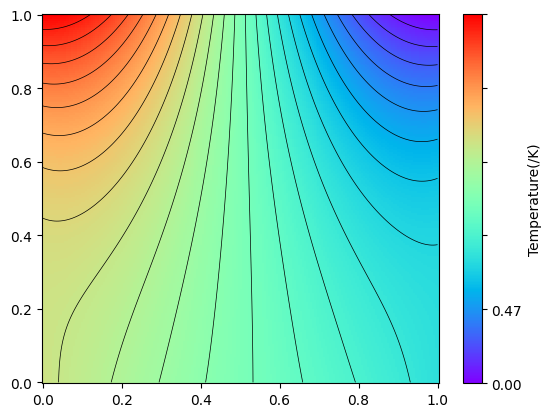

In [76]:
x=torch.linspace(0.0, 1.0, 200).requires_grad_()
y=torch.linspace(0.0, 1.0, 200).requires_grad_()
xy_tensor = torch.cartesian_prod(x, y).to(device)
        
xx = torch.squeeze(xy_tensor[:, 0])
yy = torch.squeeze(xy_tensor[:, 1])

uu=fcnn_approximator.__call__(xx,yy)
print(uu.shape)
uu=(1-yy)*uu+2*xx**3-3*xx**2+1
uu=uu.detach().cpu().numpy()
fem=pd.read_csv('./data/new.txt',delimiter=r'\s+')
uu_di=abs(uu*args.maxf+303.15-fem['T'].values)

x=x.detach().cpu().numpy()
y=y.detach().cpu().numpy()

x, y = np.meshgrid(x,y)

heatmap=plt.pcolormesh(x, y, uu.reshape(x.shape).T, cmap='rainbow')
plt.contour(x, y, uu.reshape(x.shape).T, 30,colors='black', linewidths=0.5)
cbar=plt.colorbar(heatmap,label='Temperature(/K)')
# 添加轴标签
# 手动设置 colorbar 的刻度标签
# cbar_ticks = [uu_di.min(), uu_di.max()]  # 设置刻度标签为最小值和最大值
# cbar.set_ticks(cbar_ticks)

#设置刻度标签的文本，可以使用字符串格式化来显示具体值
cbar_ticklabels = [f'{tick:.2f}' for tick in cbar_ticks]
cbar.set_ticklabels(cbar_ticklabels)
# plt.set_xlabel('r')
# plt.set_ylabel('z')
# plt.set_title('Heatmap_compare')
plt.show()

In [1]:
import torch
import numpy as np
import pandas as pd

# 生成两个mesh
solution_xx, solution_yy = torch.meshgrid(torch.linspace(0.0, 1.0, 200), torch.linspace(0.0, 1.0, 200))

# 展平两个mesh
solution_xx_flat = (solution_xx*(0.1695-0.135)+0.135).flatten()
solution_yy_flat = (solution_yy*0.02).flatten()

# 将结果转换为 NumPy 数组
solution_data = np.column_stack((solution_xx_flat.numpy(), solution_yy_flat.numpy()))

# 创建 DataFrame
df = pd.DataFrame(solution_data, columns=['R', 'Z'])

# 保存到 txt 文件
df.to_csv('data/solution_data.txt', index=False, sep='\t')  # 使用制表符分隔

# 打印 DataFrame
#print(df)

/Users/yst/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
